# Udacity Deep Learning Project - Digit Localizer - Part 2

Author: Lei Mao <br>
Late revised on: 1/10/2016 <br>

Notes: Bounding box regression

## Convolutional Neural Network (CNN) Regression for SVHN Bounding Box Dataset

### Import libraries required

In [67]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import os
from six.moves import cPickle as pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [68]:
%autosave 0

Autosave disabled


### Load SVHN_BB dataset

In [69]:
# Read training dataset
SVHN_folder = 'data/SVHN_BB/'
pickle_file = 'train_set.pickle'

with open(SVHN_folder + pickle_file, 'rb') as f:
    print('Loading data ...')
    print('This may consume a lot of memories.')
    save = pickle.load(f)
    SVHN_train_dataset = save['dataset']
    SVHN_train_labels = save['labels']
    del save  # hint to help gc free up memory
    print('SVHN training set', SVHN_train_dataset.shape, SVHN_train_labels.shape)

Loading data ...
This may consume a lot of memories.
('SVHN training set', (300618, 48, 48, 3), (300618, 4))


In [70]:
# Shuffle training set
SVHN_train_dataset, SVHN_train_labels = shuffle(SVHN_train_dataset, SVHN_train_labels, random_state = 0)

Extra dataset is somewhat easier compared to training and test datasets. I have tested and found that if I include a lot of extra dataset in the training sets, there might be significant difference between the training and test predictions.

# Read extra dataset
SVHN_folder = 'data/SVHN_BB/'
pickle_file = 'extra_set.pickle'

with open(SVHN_folder + pickle_file, 'rb') as f:
    print('Loading data ...')
    print('This may consume a lot of memories.')
    save = pickle.load(f)
    SVHN_extra_dataset = save['dataset']
    SVHN_extra_labels = save['labels']
    del save  # hint to help gc free up memory
    print('SVHN extra set', SVHN_extra_dataset.shape, SVHN_extra_labels.shape)

SVHN_train_dataset = np.concatenate((SVHN_train_dataset, SVHN_extra_dataset), axis = 0)
del SVHN_extra_dataset
SVHN_train_labels = np.concatenate((SVHN_train_labels, SVHN_extra_labels), axis = 0)
del SVHN_extra_labels

In [71]:
# Read test dataset
SVHN_folder = 'data/SVHN_BB/'
pickle_file = 'test_set.pickle'

with open(SVHN_folder + pickle_file, 'rb') as f:
    print('Loading data ...')
    print('This may consume a lot of memories.')
    save = pickle.load(f)
    SVHN_test_dataset = save['dataset']
    SVHN_test_labels = save['labels']
    del save  # hint to help gc free up memory
    print('SVHN test set', SVHN_test_dataset.shape, SVHN_test_labels.shape)

Loading data ...
This may consume a lot of memories.
('SVHN test set', (13068, 48, 48, 3), (13068, 4))


In [72]:
# Split test dataset to test and validation datasets
SVHN_test_dataset, SVHN_valid_dataset, SVHN_test_labels, SVHN_valid_labels = train_test_split(
    SVHN_test_dataset, SVHN_test_labels, test_size = 5./10, random_state = 0)

In [73]:
# Check the size of each dataset
print('Training set: %d images and %d labels.' %(len(SVHN_train_dataset), len(SVHN_train_labels)))
print('Validation set: %d images and %d labels.' %(len(SVHN_valid_dataset), len(SVHN_valid_labels)))
print('Test set: %d images and %d labels.' %(len(SVHN_test_dataset), len(SVHN_test_labels)))

Training set: 300618 images and 300618 labels.
Validation set: 6534 images and 6534 labels.
Test set: 6534 images and 6534 labels.


* I feel that for bounding box regression image_grayed and image normalization will sacrifice too much data quality.
* I think probably the best way to do bounding box regression is to keep the color.

In [74]:
def image_grayed(dataset):
    dataset_grayed = np.zeros(shape = (dataset.shape[0], dataset.shape[1], dataset.shape[2], 1), dtype = np.uint8)
    for i in xrange(len(dataset)):
        for j in xrange(dataset.shape[3]):
            dataset_grayed[i, :, :, 0] += dataset[i, :, :, j]
        dataset_grayed[i] = dataset_grayed[i] // dataset.shape[3]
    return dataset_grayed

In [75]:
def image_norm(dataset):
    dataset_norm = np.zeros(shape = (dataset.shape[0], dataset.shape[1], dataset.shape[2], dataset.shape[3]), dtype = np.uint8)
    for i in xrange(len(dataset)):
        dataset_norm[i] = dataset[i] - np.average(dataset[i])
    return dataset_norm

In [76]:
train_dataset = image_norm(SVHN_train_dataset)
valid_dataset = image_norm(SVHN_valid_dataset)
test_dataset = image_norm(SVHN_test_dataset)

train_dataset = SVHN_train_dataset
valid_dataset = SVHN_valid_dataset
test_dataset = SVHN_test_dataset

In [77]:
train_labels = SVHN_train_labels
valid_labels = SVHN_valid_labels
test_labels = SVHN_test_labels

In [78]:
def bbox_show(img, bbox_label):
    '''bbox_label: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    img_data = img.copy()
    cv2.rectangle(img_data, (bbox_label[0], bbox_label[1]), (bbox_label[2], bbox_label[3]), (0,255,0), 1)
    fig = plt.figure()
    plotwindow = fig.add_subplot(111)
    plt.imshow(img_data)
    plt.show()
    return

In [79]:
def bbox_compare(img, bbox_label, bbox_prediction):
    '''bbox_label: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    img_data = img.copy()
    cv2.rectangle(img_data, (bbox_label[0], bbox_label[1]), (bbox_label[2], bbox_label[3]), (0,255,0), 1)
    cv2.rectangle(img_data, (bbox_prediction[0], bbox_prediction[1]), (bbox_prediction[2], bbox_prediction[3]), (255,0,0), 1)
    fig = plt.figure()
    plotwindow = fig.add_subplot(111)
    plt.imshow(img_data)
    plt.show()
    return

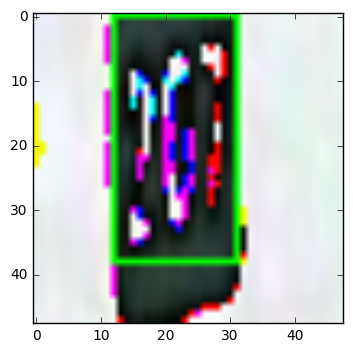

In [80]:
image_index = np.random.randint(len(train_dataset))
image_data = train_dataset[image_index]
image_label = train_labels[image_index]

bbox_show(image_data, bbox_label = image_label)

### Define IoU evaluation function

In [81]:
'''PS: Shit. There might be functions in OpenCV to calculate the minimal rectangle covering two rectangles. 
I might not have to spend that much time developing my own algorithm and function.
https://putuyuwono.wordpress.com/2015/06/26/intersection-and-union-two-rectangles-opencv/'''

def union(r1, r2):
    '''Minimal rectangle covering two rectangles.
    Python OpenCV rectangle format: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    topleft_x = min(r1[0], r2[0])
    topleft_y = min(r1[1], r2[1])
    bottomright_x = max(r1[2], r2[2])
    bottomright_y = max(r1[3], r2[3])
    return (topleft_x, topleft_y, bottomright_x, bottomright_y)

def intersection(r1, r2):
    '''Intersection of two rectangles.
    Python OpenCV rectangle format: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    topleft_x = max(r1[0], r2[0])
    topleft_y = max(r1[1], r2[1])
    bottomright_x = min(r1[2], r2[2])
    bottomright_y = min(r1[3], r2[3])
    if (bottomright_x - topleft_x < 0) or (bottomright_y - bottomright_x < 0): 
        return (0, 0, 0, 0) # or ()
    else:
        return (topleft_x, topleft_y, bottomright_x, bottomright_y)
    
def IoU_calculation(r1, r2):
    '''Calculate the IoU between two OpenCV rectangles.
    It seems that, unlike C++, OpenCV python does not have rectangle object,
    which means I might not be able to use the library union and intersection as in C++.
    Python OpenCV rectangle format: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    r3 = intersection(r1, r2)
    intersection_area = (r3[2] - r3[0]) * (r3[3] - r3[1])
    union_area = (r1[2] - r1[0]) * (r1[3] - r1[1]) + (r2[2] - r2[0]) * (r2[3] - r2[1]) - intersection_area
    
    # To prevent division 0
    if union_area <= 0:
        return 0
    
    IoU = float(intersection_area) / union_area
    return IoU

def union_2(r1, r2):
    '''Minimal rectangle covering two rectangles.
    Python OpenCV rectangle format: [x, y, w, h]'''
    x = min(r1[0], r2[0])
    y = min(r1[1], r2[1])
    w = max(r1[0] + r1[2], r2[0] + r2[2]) - x
    h = max(r1[1] + r1[3], r2[1] + r2[3]) - y
    return (x, y, w, h)

def intersection_2(r1, r2):
    '''Intersection of two rectangles.
    Python OpenCV rectangle format: [x, y, w, h]'''
    x = max(r1[0], r2[0])
    y = max(r1[1], r2[1])
    w = min(r1[0] + r1[2], r2[0] + r2[2]) - x
    h = min(r1[1] + r1[3], r2[1] + r2[3]) - y
    if w < 0 or h < 0: 
        return (0, 0, 0, 0) # or ()
    else:
        return (x, y, w, h)    
    
def IoU_calculation_2(r1, r2):
    '''Calculate the IoU between two OpenCV rectangles.
    It seems that, unlike C++, OpenCV python does not have rectangle object,
    which means I might not be able to use the library union and intersection as in C++.
    Python OpenCV rectangle format: [x, y, w, h]'''
    r3 = intersection_2(r1, r2)
    intersection_area = r3[2] * r3[3]
    union_area = r1[2] * r1[3] + r2[2] * r2[3] - intersection_area
    
    # To prevent division 0
    if union_area <= 0:
        return 0
    
    IoU = float(intersection_area) / union_area
    return IoU


### Build Deep Convolutional Neural Network using Tensorflow

In [86]:
batch_size = 64
patch_size = 3
depth_1 = 16
depth_2 = 32
depth_3 = 64

num_hidden = 64
keep_prob = 0.8

num_image_rows = 48
num_image_columns = 48
num_channels = 3
num_labels = 4

L2_beta = 0.01

valid_size = len(valid_dataset)
test_size = len(test_dataset)

#train_size = len(SVHN_train_labels)

graph = tf.Graph()

with graph.as_default():
    
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, num_image_rows, num_image_columns, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset, dtype=tf.float32)
    tf_valid_labels = tf.constant(valid_labels, dtype=tf.float32)
    
    tf_test_dataset = tf.constant(test_dataset, dtype=tf.float32)
    tf_test_labels = tf.constant(test_labels, dtype=tf.float32)
    
    tf_regressor_weights = tf.constant([0.25, 0.25, 0.25, 0.25], dtype=tf.float32)

    # Variables
    cnn_1_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth_1], stddev=0.1), 
                                name = 'CNN_1_1_W')
    cnn_1_1_biases = tf.Variable(tf.zeros([depth_1]), name = 'CNN_1_1_B')

    cnn_1_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_1], stddev=0.1), 
                                name = 'CNN_1_2_W')
    cnn_1_2_biases = tf.Variable(tf.zeros([depth_1]), name = 'CNN_1_2_B')    

    cnn_2_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_2], stddev=0.1), 
                                name = 'CNN_2_1_W')
    cnn_2_1_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]), name = 'CNN_2_1_B')

    cnn_2_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_2], stddev=0.1), 
                                name = 'CNN_2_2_W')
    cnn_2_2_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]), name = 'CNN_2_2_B')

    cnn_3_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_3], stddev=0.1), 
                                name = 'CNN_3_1_W')
    cnn_3_1_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]), name = 'CNN_3_1_B')

    cnn_3_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_3, depth_3], stddev=0.1), 
                                name = 'CNN_3_2_W')
    cnn_3_2_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]), name = 'CNN_3_2_B')

    fc_1_weights = tf.Variable(tf.truncated_normal(
            [num_image_rows // 8 * num_image_columns // 8 * depth_3, num_hidden], stddev=0.1), name = 'FC_1_W')
    fc_1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name = 'FC_1_B')
    
    logistic_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1), name = 'H_W')
    logistic_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name = 'H_B')
    
    # Model
    def model(data, keep_prob = keep_prob):
        
        conv = tf.nn.conv2d(data, cnn_1_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_1_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_1_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_1_2_biases)        
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        
        conv = tf.nn.conv2d(hidden, cnn_2_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_2_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_2_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_2_2_biases)
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        conv = tf.nn.conv2d(hidden, cnn_3_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_3_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_3_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_3_2_biases)
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
        hidden = tf.nn.dropout(hidden, keep_prob = keep_prob)
        
        logits = tf.matmul(hidden, logistic_weights) + logistic_biases
        
        return logits

    # Training computation
    train_logits_dropout = model(tf_train_dataset, keep_prob = keep_prob)
    
    L2_loss = L2_beta * (tf.nn.l2_loss(logistic_weights) + tf.nn.l2_loss(logistic_biases))
    
    train_loss = L2_loss + tf.reduce_sum(
        tf.multiply(tf.reduce_sum(tf.square(train_logits_dropout - tf_train_labels), 0), tf_regressor_weights)) / batch_size

    # Optimizer
    #optimizer = tf.train.GradientDescentOptimizer(0.000005).minimize(train_loss)
    
    # Optimizer.
    global_step = tf.Variable(0)
    #learning rate with exponential decay.
    learning_rate = tf.train.exponential_decay(
        learning_rate = 0.015, global_step = global_step, decay_steps = 10000, decay_rate = 0.95, staircase = True) 
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(train_loss, global_step = global_step)
    
    
    # Optimizer.
    #batch = tf.Variable(0, dtype=tf.float32)
    # Decay once per epoch, using an exponential schedule starting at 0.01.
    #learning_rate = tf.train.exponential_decay(0.01, batch * batch_size, train_size, 0.95, staircase=True)
    # Use simple momentum for the optimization.
    #optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(train_loss, global_step=batch)

    # Predict the logits in training set
    train_logits = model(tf_train_dataset, keep_prob = 1.0)
    train_error = tf.reduce_sum(
        tf.multiply(tf.reduce_sum(tf.square(train_logits - tf_train_labels), 0), tf_regressor_weights)) / batch_size
    
    # Predict the logits in validation set
    valid_logits = model(tf_valid_dataset, keep_prob = 1.0)
    valid_error = tf.reduce_sum(
        tf.multiply(tf.reduce_sum(tf.square(valid_logits - tf_valid_labels), 0), tf_regressor_weights)) / valid_size    
    
    # Predict the logits in test set
    test_logits = model(tf_test_dataset, keep_prob = 1.0)
    test_error = tf.reduce_sum(
        tf.multiply(tf.reduce_sum(tf.square(test_logits - tf_test_labels), 0), tf_regressor_weights)) / test_size 
    
    # Prediction of single test data
    # Input data
    tf_test_single = tf.placeholder(tf.float32, shape=(1, num_image_rows, num_image_columns, num_channels))
    # Predict the logits in single test data
    test_logits_single = model(tf_test_single, keep_prob = 1.0) 
    
    saver = tf.train.Saver()

Initialized
Minibatch loss at step 0: 729.428955
Minibatch error at step 0: 733.245850
Validation set loss at step 0: 325.455963
Validation set average IoU at step 0: -0.000472


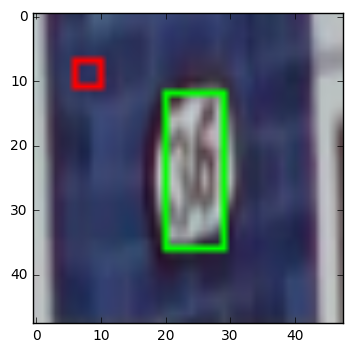

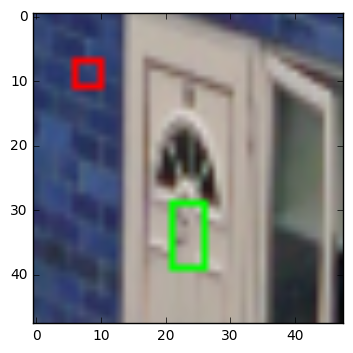

Minibatch loss at step 100: 41.902897
Minibatch error at step 100: 36.209389
Minibatch loss at step 200: 33.918499
Minibatch error at step 200: 26.314766
Minibatch loss at step 300: 36.447731
Minibatch error at step 300: 27.373518
Minibatch loss at step 400: 35.714607
Minibatch error at step 400: 29.419626
Minibatch loss at step 500: 31.111677
Minibatch error at step 500: 27.471025
Validation set loss at step 500: 47.952579
Validation set average IoU at step 500: 0.388235


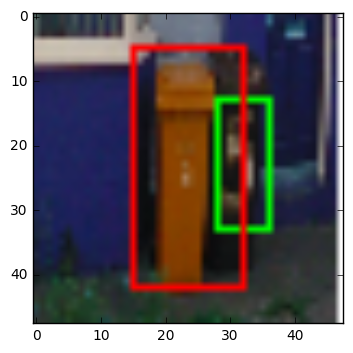

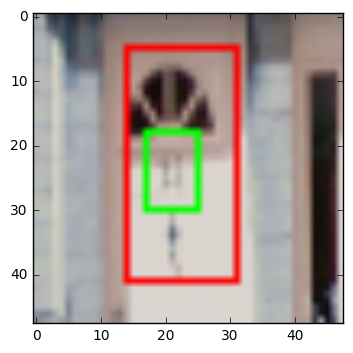

Minibatch loss at step 600: 35.922932
Minibatch error at step 600: 32.767502
Minibatch loss at step 700: 35.413334
Minibatch error at step 700: 28.723833
Minibatch loss at step 800: 33.618008
Minibatch error at step 800: 23.221935
Minibatch loss at step 900: 25.290030
Minibatch error at step 900: 20.748596
Minibatch loss at step 1000: 18.877031
Minibatch error at step 1000: 13.729828
Validation set loss at step 1000: 42.332668
Validation set average IoU at step 1000: 0.404967


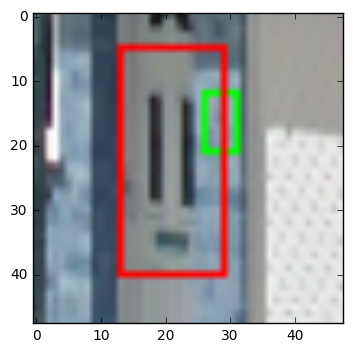

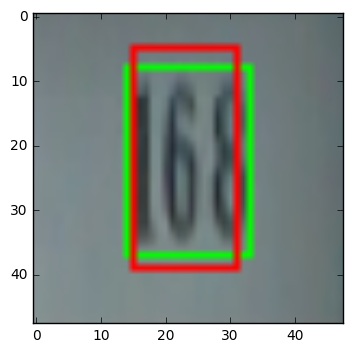

Minibatch loss at step 1100: 24.211365
Minibatch error at step 1100: 16.872219
Minibatch loss at step 1200: 29.534327
Minibatch error at step 1200: 21.756592
Minibatch loss at step 1300: 30.796974
Minibatch error at step 1300: 21.929775
Minibatch loss at step 1400: 28.065306
Minibatch error at step 1400: 22.027555
Minibatch loss at step 1500: 22.125601
Minibatch error at step 1500: 16.259718
Validation set loss at step 1500: 41.241440
Validation set average IoU at step 1500: 0.424320


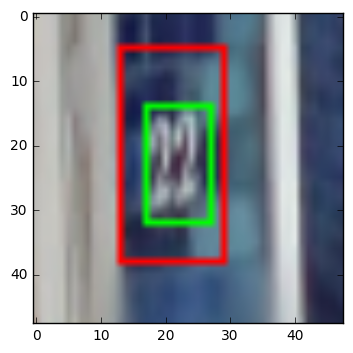

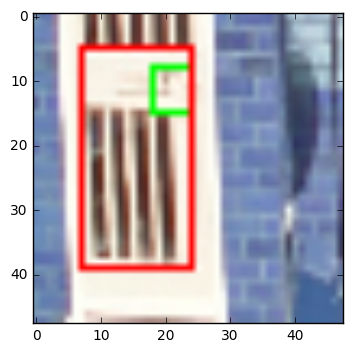

Minibatch loss at step 1600: 25.829206
Minibatch error at step 1600: 19.750458
Minibatch loss at step 1700: 23.394823
Minibatch error at step 1700: 16.667828
Minibatch loss at step 1800: 25.263979
Minibatch error at step 1800: 17.881655
Minibatch loss at step 1900: 25.557022
Minibatch error at step 1900: 15.432634
Minibatch loss at step 2000: 23.362183
Minibatch error at step 2000: 18.175014
Validation set loss at step 2000: 37.274868
Validation set average IoU at step 2000: 0.441021


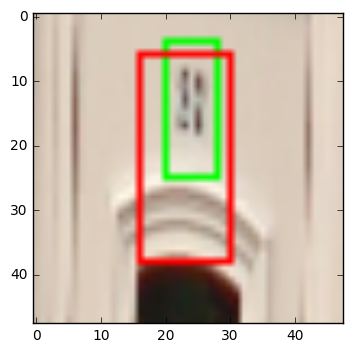

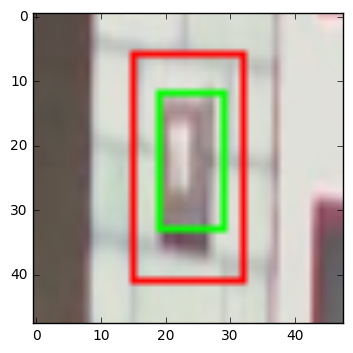

Minibatch loss at step 2100: 22.669027
Minibatch error at step 2100: 15.245433
Minibatch loss at step 2200: 27.438480
Minibatch error at step 2200: 18.525604
Minibatch loss at step 2300: 22.852404
Minibatch error at step 2300: 15.900296
Minibatch loss at step 2400: 21.497427
Minibatch error at step 2400: 15.686369
Minibatch loss at step 2500: 23.489836
Minibatch error at step 2500: 15.136061
Validation set loss at step 2500: 33.813744
Validation set average IoU at step 2500: 0.440563


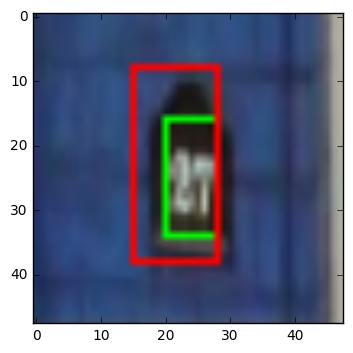

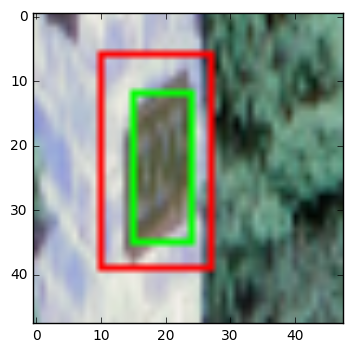

Minibatch loss at step 2600: 26.257492
Minibatch error at step 2600: 17.646631
Minibatch loss at step 2700: 19.983896
Minibatch error at step 2700: 14.628400
Minibatch loss at step 2800: 17.088850
Minibatch error at step 2800: 12.398830
Minibatch loss at step 2900: 25.658062
Minibatch error at step 2900: 17.312769
Minibatch loss at step 3000: 19.021975
Minibatch error at step 3000: 11.600271
Validation set loss at step 3000: 28.145676
Validation set average IoU at step 3000: 0.467376


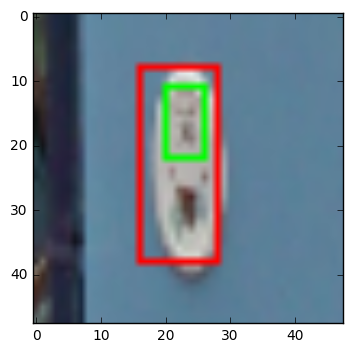

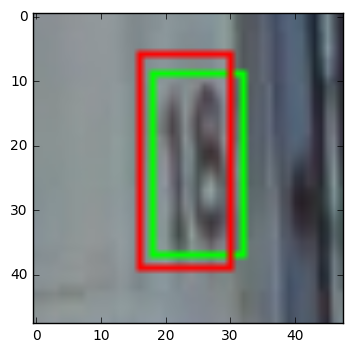

Minibatch loss at step 3100: 23.480848
Minibatch error at step 3100: 17.269539
Minibatch loss at step 3200: 21.452986
Minibatch error at step 3200: 14.369222
Minibatch loss at step 3300: 20.004208
Minibatch error at step 3300: 13.393487
Minibatch loss at step 3400: 17.165091
Minibatch error at step 3400: 10.003703
Minibatch loss at step 3500: 14.383334
Minibatch error at step 3500: 9.426868
Validation set loss at step 3500: 28.461475
Validation set average IoU at step 3500: 0.479486


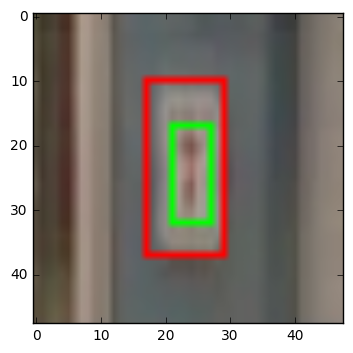

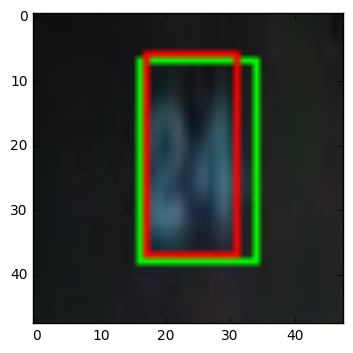

Minibatch loss at step 3600: 20.078957
Minibatch error at step 3600: 9.832897
Minibatch loss at step 3700: 23.577534
Minibatch error at step 3700: 11.644535
Minibatch loss at step 3800: 17.936686
Minibatch error at step 3800: 10.382061
Minibatch loss at step 3900: 19.653355
Minibatch error at step 3900: 12.343280
Minibatch loss at step 4000: 17.980610
Minibatch error at step 4000: 14.401761
Validation set loss at step 4000: 27.984854
Validation set average IoU at step 4000: 0.470731


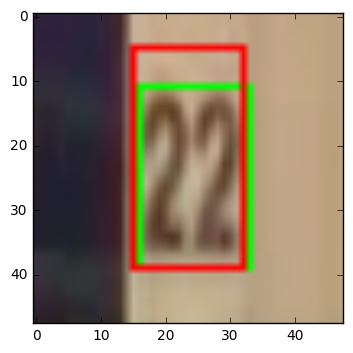

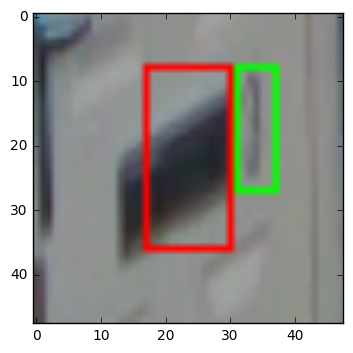

Minibatch loss at step 4100: 15.061199
Minibatch error at step 4100: 9.286751
Minibatch loss at step 4200: 20.844021
Minibatch error at step 4200: 13.876690
Minibatch loss at step 4300: 19.294025
Minibatch error at step 4300: 11.391478
Minibatch loss at step 4400: 18.167023
Minibatch error at step 4400: 9.139823
Minibatch loss at step 4500: 14.820769
Minibatch error at step 4500: 9.325393
Validation set loss at step 4500: 28.725000
Validation set average IoU at step 4500: 0.480058


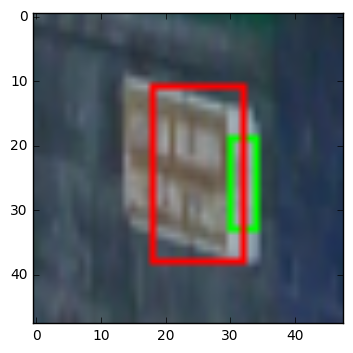

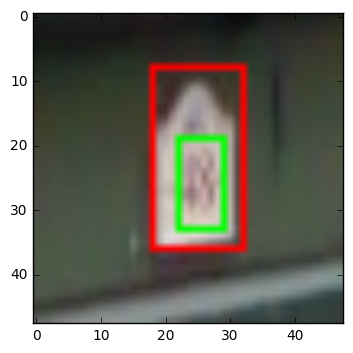

Minibatch loss at step 4600: 17.672585
Minibatch error at step 4600: 9.986984
Minibatch loss at step 4700: 19.792194
Minibatch error at step 4700: 14.150319
Minibatch loss at step 4800: 18.897394
Minibatch error at step 4800: 12.987204
Minibatch loss at step 4900: 18.720337
Minibatch error at step 4900: 9.607221
Minibatch loss at step 5000: 16.743620
Minibatch error at step 5000: 10.119244
Validation set loss at step 5000: 26.508528
Validation set average IoU at step 5000: 0.481673


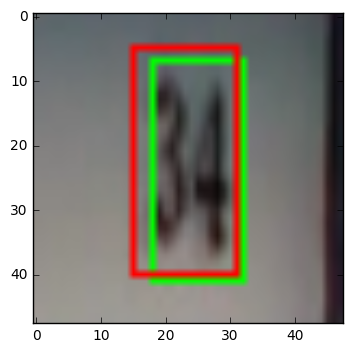

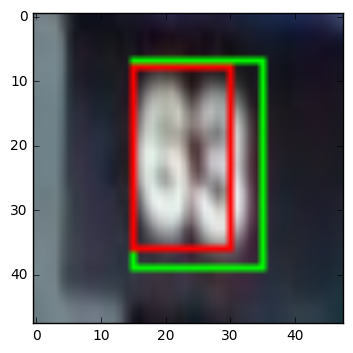

Minibatch loss at step 5100: 23.620537
Minibatch error at step 5100: 14.882411
Minibatch loss at step 5200: 21.482403
Minibatch error at step 5200: 14.234017
Minibatch loss at step 5300: 16.064495
Minibatch error at step 5300: 10.159662
Minibatch loss at step 5400: 17.515158
Minibatch error at step 5400: 12.954779
Minibatch loss at step 5500: 16.919600
Minibatch error at step 5500: 9.181501
Validation set loss at step 5500: 29.611944
Validation set average IoU at step 5500: 0.482909


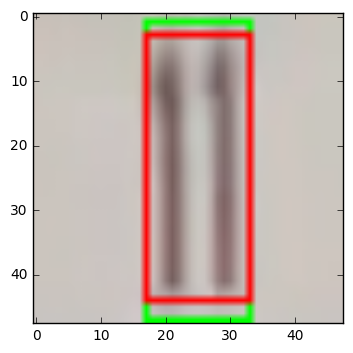

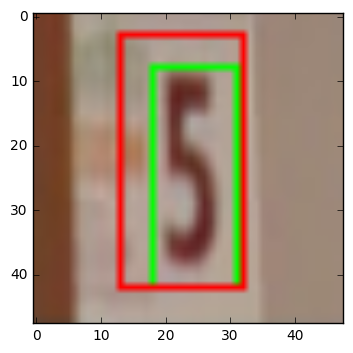

Minibatch loss at step 5600: 15.622954
Minibatch error at step 5600: 8.594269
Minibatch loss at step 5700: 17.303658
Minibatch error at step 5700: 11.511929
Minibatch loss at step 5800: 19.514610
Minibatch error at step 5800: 11.776615
Minibatch loss at step 5900: 14.795819
Minibatch error at step 5900: 9.209291
Minibatch loss at step 6000: 16.299168
Minibatch error at step 6000: 8.885174
Validation set loss at step 6000: 27.803921
Validation set average IoU at step 6000: 0.481819


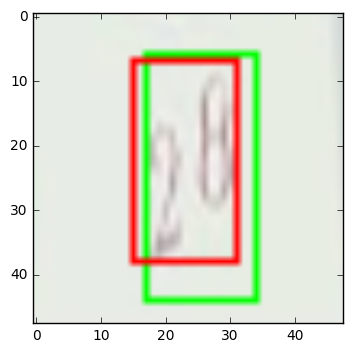

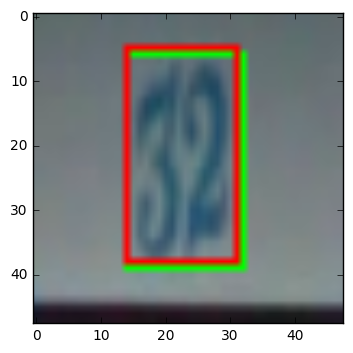

Minibatch loss at step 6100: 24.457447
Minibatch error at step 6100: 17.338596
Minibatch loss at step 6200: 19.224407
Minibatch error at step 6200: 8.514890
Minibatch loss at step 6300: 13.650810
Minibatch error at step 6300: 9.550485
Minibatch loss at step 6400: 15.347622
Minibatch error at step 6400: 10.020147
Minibatch loss at step 6500: 14.874642
Minibatch error at step 6500: 9.629225
Validation set loss at step 6500: 25.312517
Validation set average IoU at step 6500: 0.476666


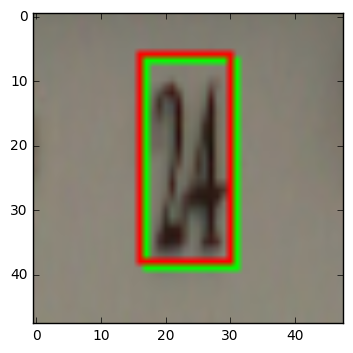

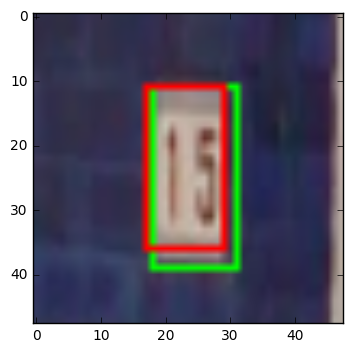

Minibatch loss at step 6600: 15.598903
Minibatch error at step 6600: 9.949736
Minibatch loss at step 6700: 16.995943
Minibatch error at step 6700: 9.385732
Minibatch loss at step 6800: 16.597282
Minibatch error at step 6800: 10.785433
Minibatch loss at step 6900: 16.075735
Minibatch error at step 6900: 10.134185
Minibatch loss at step 7000: 17.075500
Minibatch error at step 7000: 11.028927
Validation set loss at step 7000: 25.884281
Validation set average IoU at step 7000: 0.487459


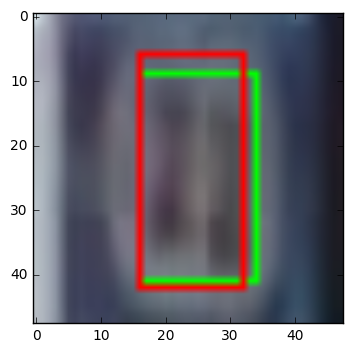

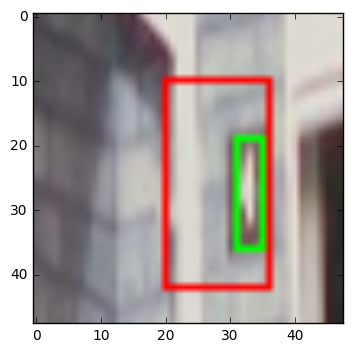

Minibatch loss at step 7100: 17.588697
Minibatch error at step 7100: 10.977523
Minibatch loss at step 7200: 22.197586
Minibatch error at step 7200: 14.919058
Minibatch loss at step 7300: 18.253447
Minibatch error at step 7300: 13.352755
Minibatch loss at step 7400: 18.308298
Minibatch error at step 7400: 11.672089
Minibatch loss at step 7500: 14.082311
Minibatch error at step 7500: 6.995774
Validation set loss at step 7500: 27.923744
Validation set average IoU at step 7500: 0.490854


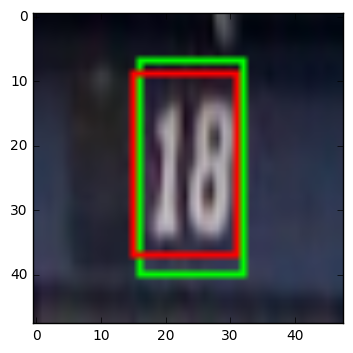

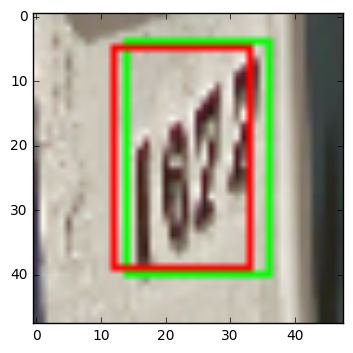

Minibatch loss at step 7600: 15.782363
Minibatch error at step 7600: 9.235760
Minibatch loss at step 7700: 16.889154
Minibatch error at step 7700: 10.380700
Minibatch loss at step 7800: 13.174258
Minibatch error at step 7800: 7.834908
Minibatch loss at step 7900: 17.599085
Minibatch error at step 7900: 11.133026
Minibatch loss at step 8000: 16.706381
Minibatch error at step 8000: 8.311500
Validation set loss at step 8000: 27.206713
Validation set average IoU at step 8000: 0.495432


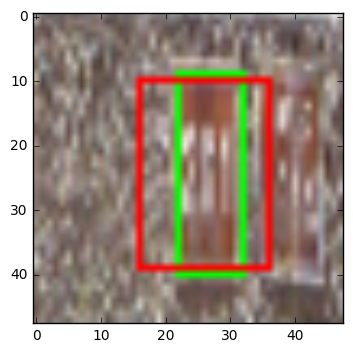

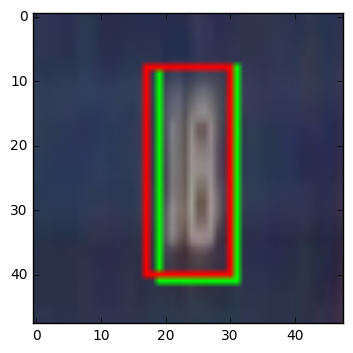

Minibatch loss at step 8100: 24.017967
Minibatch error at step 8100: 15.868160
Minibatch loss at step 8200: 14.333513
Minibatch error at step 8200: 9.230530
Minibatch loss at step 8300: 16.362839
Minibatch error at step 8300: 11.020591
Minibatch loss at step 8400: 20.195761
Minibatch error at step 8400: 13.373580
Minibatch loss at step 8500: 16.188921
Minibatch error at step 8500: 9.692504
Validation set loss at step 8500: 24.729832
Validation set average IoU at step 8500: 0.489658


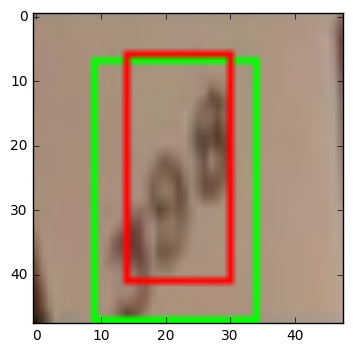

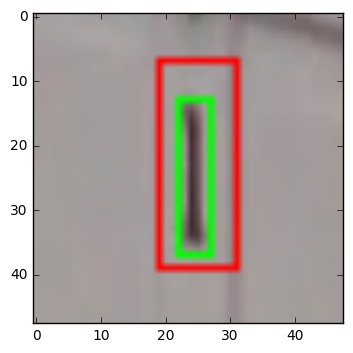

Minibatch loss at step 8600: 16.659910
Minibatch error at step 8600: 12.446774
Minibatch loss at step 8700: 17.759199
Minibatch error at step 8700: 12.136715
Minibatch loss at step 8800: 17.237621
Minibatch error at step 8800: 11.023342
Minibatch loss at step 8900: 22.259464
Minibatch error at step 8900: 15.128532
Minibatch loss at step 9000: 16.361937
Minibatch error at step 9000: 9.782335
Validation set loss at step 9000: 24.966991
Validation set average IoU at step 9000: 0.492087


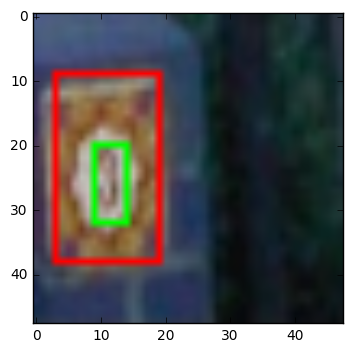

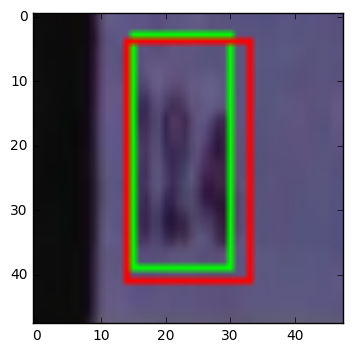

Minibatch loss at step 9100: 16.975328
Minibatch error at step 9100: 11.400614
Minibatch loss at step 9200: 20.892668
Minibatch error at step 9200: 13.198741
Minibatch loss at step 9300: 14.060648
Minibatch error at step 9300: 7.798921
Minibatch loss at step 9400: 21.234760
Minibatch error at step 9400: 12.172550
Minibatch loss at step 9500: 11.728493
Minibatch error at step 9500: 7.158993
Validation set loss at step 9500: 25.496399
Validation set average IoU at step 9500: 0.495489


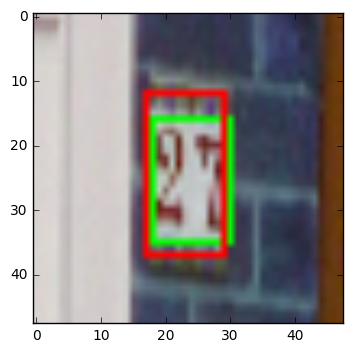

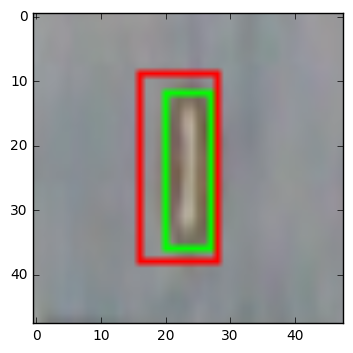

Minibatch loss at step 9600: 14.219213
Minibatch error at step 9600: 8.158953
Minibatch loss at step 9700: 16.786743
Minibatch error at step 9700: 8.628622
Minibatch loss at step 9800: 15.946110
Minibatch error at step 9800: 10.490267
Minibatch loss at step 9900: 17.510414
Minibatch error at step 9900: 10.278807
Minibatch loss at step 10000: 15.941405
Minibatch error at step 10000: 9.053117
Validation set loss at step 10000: 26.236795
Validation set average IoU at step 10000: 0.494029


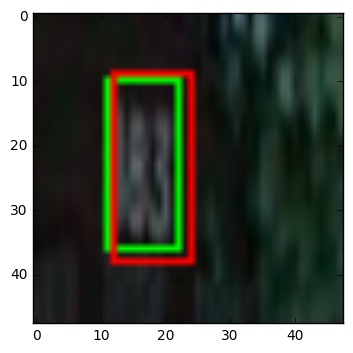

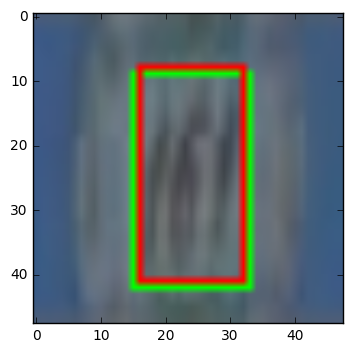

Minibatch loss at step 10100: 18.114079
Minibatch error at step 10100: 10.841672
Minibatch loss at step 10200: 16.809805
Minibatch error at step 10200: 7.694865
Minibatch loss at step 10300: 19.027266
Minibatch error at step 10300: 9.763974
Minibatch loss at step 10400: 17.695133
Minibatch error at step 10400: 11.346217
Minibatch loss at step 10500: 14.914935
Minibatch error at step 10500: 10.349697
Validation set loss at step 10500: 25.043489
Validation set average IoU at step 10500: 0.497592


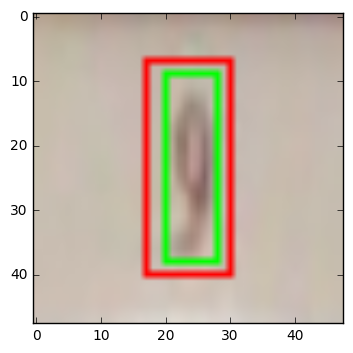

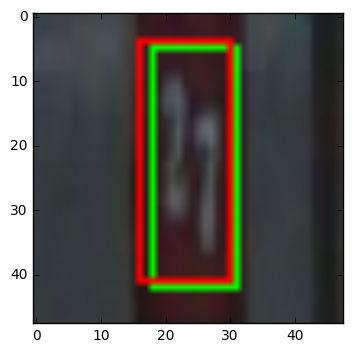

Minibatch loss at step 10600: 14.090152
Minibatch error at step 10600: 9.464230
Minibatch loss at step 10700: 14.958586
Minibatch error at step 10700: 7.443959
Minibatch loss at step 10800: 18.634588
Minibatch error at step 10800: 10.809170
Minibatch loss at step 10900: 19.358061
Minibatch error at step 10900: 11.781696
Minibatch loss at step 11000: 14.906924
Minibatch error at step 11000: 9.225863
Validation set loss at step 11000: 23.913158
Validation set average IoU at step 11000: 0.501303


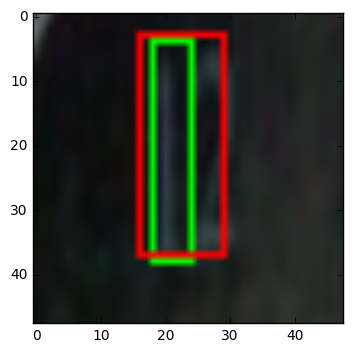

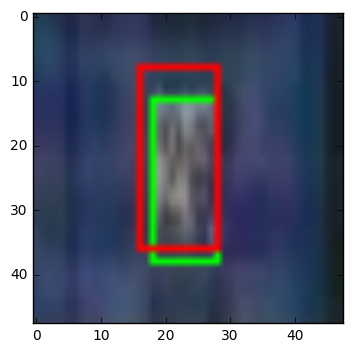

Minibatch loss at step 11100: 12.292884
Minibatch error at step 11100: 8.134615
Minibatch loss at step 11200: 14.560225
Minibatch error at step 11200: 8.692656
Minibatch loss at step 11300: 19.305307
Minibatch error at step 11300: 11.985455
Minibatch loss at step 11400: 13.774702
Minibatch error at step 11400: 7.879609
Minibatch loss at step 11500: 15.955293
Minibatch error at step 11500: 9.829291
Validation set loss at step 11500: 22.979429
Validation set average IoU at step 11500: 0.493074


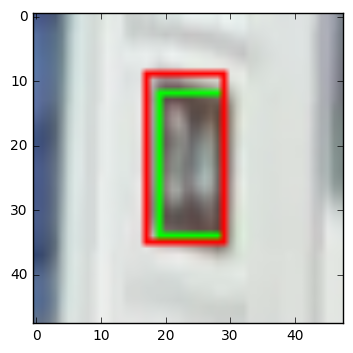

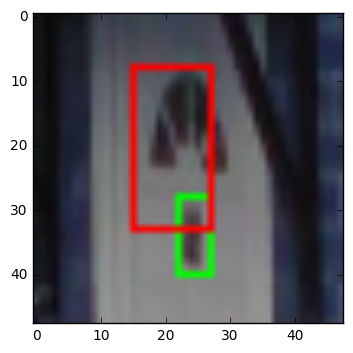

Minibatch loss at step 11600: 18.294807
Minibatch error at step 11600: 9.286736
Minibatch loss at step 11700: 15.112114
Minibatch error at step 11700: 9.109781
Minibatch loss at step 11800: 18.718691
Minibatch error at step 11800: 12.692911
Minibatch loss at step 11900: 13.772042
Minibatch error at step 11900: 8.871035
Minibatch loss at step 12000: 18.023878
Minibatch error at step 12000: 10.806385
Validation set loss at step 12000: 23.438864
Validation set average IoU at step 12000: 0.499824


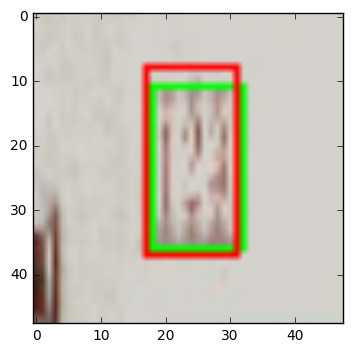

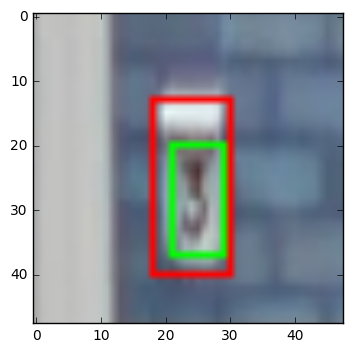

Minibatch loss at step 12100: 16.988697
Minibatch error at step 12100: 11.643632
Minibatch loss at step 12200: 17.120399
Minibatch error at step 12200: 14.182645
Minibatch loss at step 12300: 17.374371
Minibatch error at step 12300: 10.348511
Minibatch loss at step 12400: 16.853554
Minibatch error at step 12400: 10.222252
Minibatch loss at step 12500: 17.851233
Minibatch error at step 12500: 9.993025
Validation set loss at step 12500: 23.499876
Validation set average IoU at step 12500: 0.507828


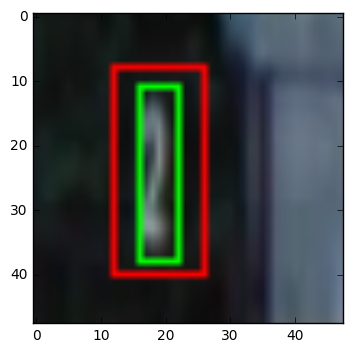

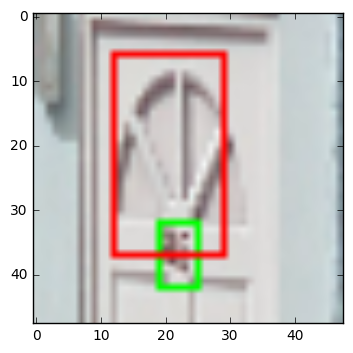

Minibatch loss at step 12600: 20.642681
Minibatch error at step 12600: 12.642403
Minibatch loss at step 12700: 17.515268
Minibatch error at step 12700: 9.699343
Minibatch loss at step 12800: 15.805771
Minibatch error at step 12800: 8.213112
Minibatch loss at step 12900: 17.158737
Minibatch error at step 12900: 9.579428
Minibatch loss at step 13000: 12.363707
Minibatch error at step 13000: 7.790443
Validation set loss at step 13000: 23.791542
Validation set average IoU at step 13000: 0.503181


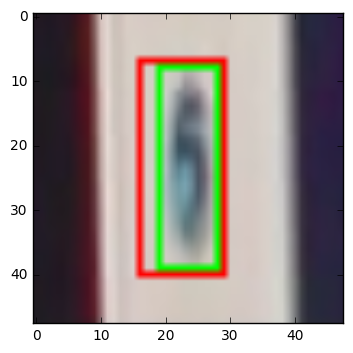

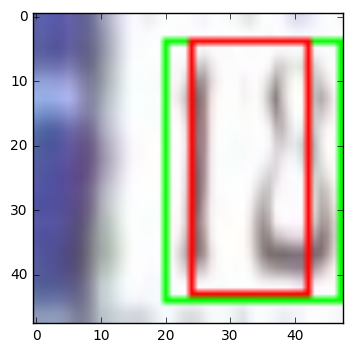

Minibatch loss at step 13100: 21.884785
Minibatch error at step 13100: 14.805234
Minibatch loss at step 13200: 12.723727
Minibatch error at step 13200: 6.383987
Minibatch loss at step 13300: 17.085436
Minibatch error at step 13300: 10.112073
Minibatch loss at step 13400: 12.450550
Minibatch error at step 13400: 7.967688
Minibatch loss at step 13500: 20.587952
Minibatch error at step 13500: 13.302745
Validation set loss at step 13500: 22.023081
Validation set average IoU at step 13500: 0.494096


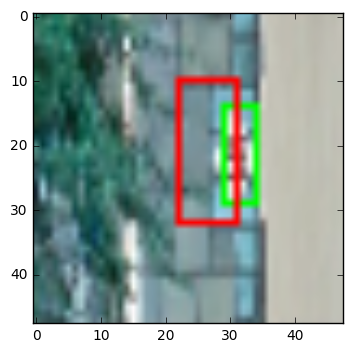

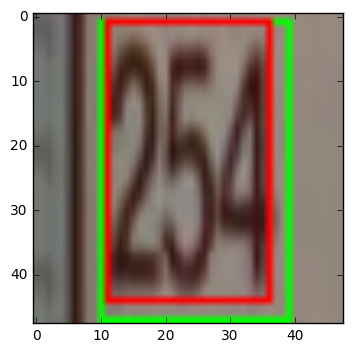

Minibatch loss at step 13600: 13.627948
Minibatch error at step 13600: 6.194691
Minibatch loss at step 13700: 10.771568
Minibatch error at step 13700: 7.535597
Minibatch loss at step 13800: 15.229311
Minibatch error at step 13800: 7.974184
Minibatch loss at step 13900: 15.357569
Minibatch error at step 13900: 9.801783
Minibatch loss at step 14000: 15.577435
Minibatch error at step 14000: 10.443064
Validation set loss at step 14000: 22.358458
Validation set average IoU at step 14000: 0.504462


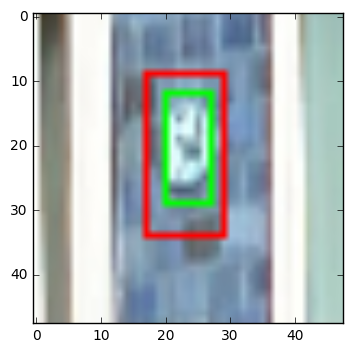

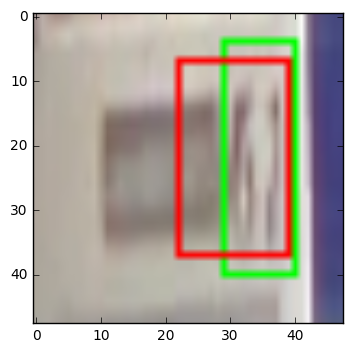

Minibatch loss at step 14100: 17.407978
Minibatch error at step 14100: 8.372952
Minibatch loss at step 14200: 15.269587
Minibatch error at step 14200: 8.392181
Minibatch loss at step 14300: 14.448230
Minibatch error at step 14300: 7.158580
Minibatch loss at step 14400: 14.030821
Minibatch error at step 14400: 8.732331
Minibatch loss at step 14500: 17.030640
Minibatch error at step 14500: 9.909344
Validation set loss at step 14500: 23.917887
Validation set average IoU at step 14500: 0.507519


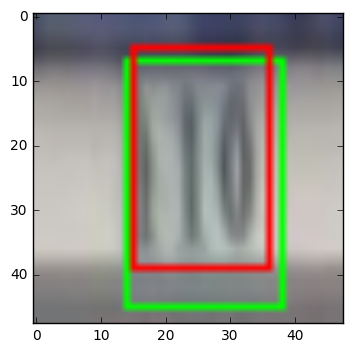

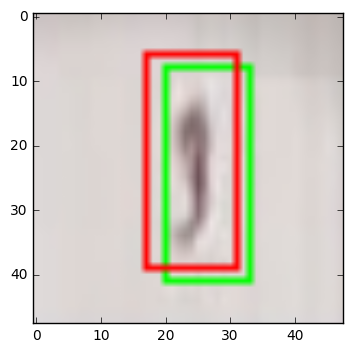

Minibatch loss at step 14600: 18.496580
Minibatch error at step 14600: 11.949542
Minibatch loss at step 14700: 10.103429
Minibatch error at step 14700: 5.370139
Minibatch loss at step 14800: 16.405373
Minibatch error at step 14800: 9.979261
Minibatch loss at step 14900: 16.914682
Minibatch error at step 14900: 10.644723
Minibatch loss at step 15000: 20.230951
Minibatch error at step 15000: 15.733757
Validation set loss at step 15000: 22.527792
Validation set average IoU at step 15000: 0.505122


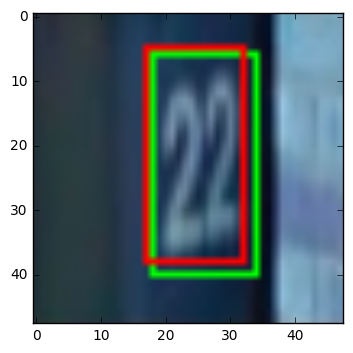

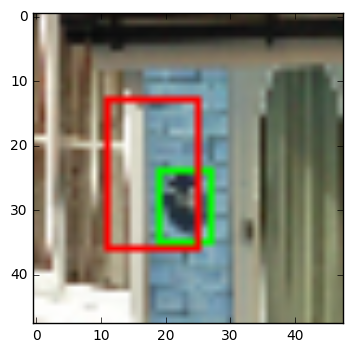

Minibatch loss at step 15100: 14.402684
Minibatch error at step 15100: 7.842052
Minibatch loss at step 15200: 16.938131
Minibatch error at step 15200: 9.936331
Minibatch loss at step 15300: 18.204861
Minibatch error at step 15300: 9.608224
Minibatch loss at step 15400: 13.302437
Minibatch error at step 15400: 7.183461
Minibatch loss at step 15500: 15.491253
Minibatch error at step 15500: 8.870790
Validation set loss at step 15500: 22.096270
Validation set average IoU at step 15500: 0.513932


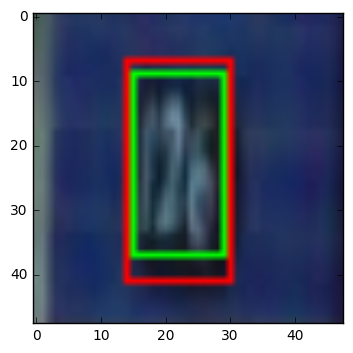

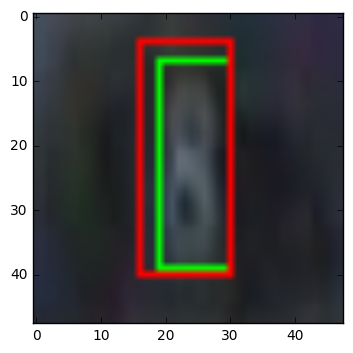

Minibatch loss at step 15600: 12.066611
Minibatch error at step 15600: 6.400862
Minibatch loss at step 15700: 16.683069
Minibatch error at step 15700: 9.849602
Minibatch loss at step 15800: 13.100571
Minibatch error at step 15800: 6.203330
Minibatch loss at step 15900: 16.595989
Minibatch error at step 15900: 9.215347
Minibatch loss at step 16000: 15.754133
Minibatch error at step 16000: 9.340115
Validation set loss at step 16000: 22.962490
Validation set average IoU at step 16000: 0.507989


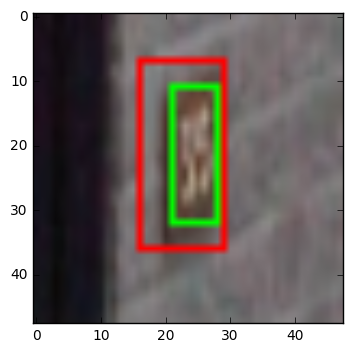

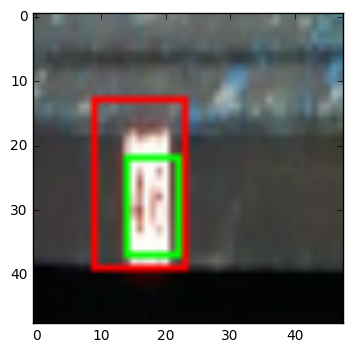

Minibatch loss at step 16100: 16.067551
Minibatch error at step 16100: 9.509157
Minibatch loss at step 16200: 13.441072
Minibatch error at step 16200: 6.468479
Minibatch loss at step 16300: 13.380396
Minibatch error at step 16300: 8.992963
Minibatch loss at step 16400: 16.144127
Minibatch error at step 16400: 9.781728
Minibatch loss at step 16500: 13.966103
Minibatch error at step 16500: 7.641294
Validation set loss at step 16500: 22.948553
Validation set average IoU at step 16500: 0.485085


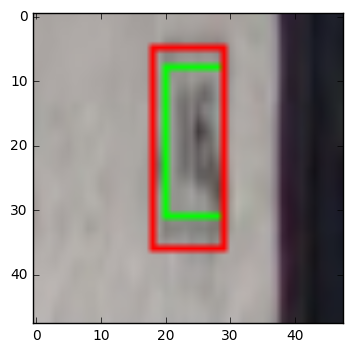

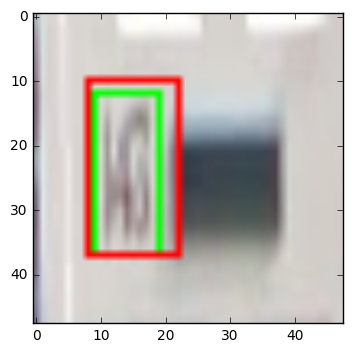

Minibatch loss at step 16600: 22.459774
Minibatch error at step 16600: 14.367935
Minibatch loss at step 16700: 16.481966
Minibatch error at step 16700: 9.577093
Minibatch loss at step 16800: 13.107222
Minibatch error at step 16800: 7.787453
Minibatch loss at step 16900: 14.473310
Minibatch error at step 16900: 6.436795
Minibatch loss at step 17000: 17.062445
Minibatch error at step 17000: 10.424788
Validation set loss at step 17000: 21.469418
Validation set average IoU at step 17000: 0.511018


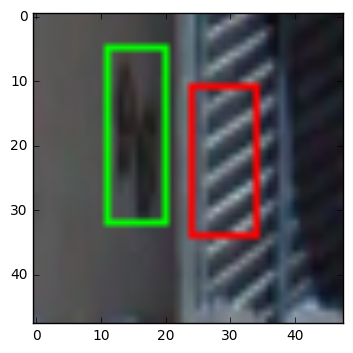

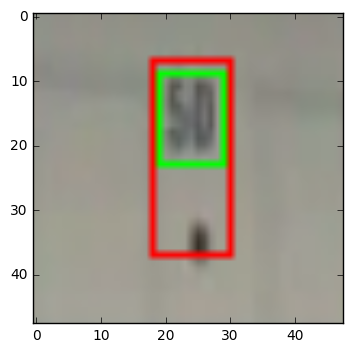

Minibatch loss at step 17100: 14.370814
Minibatch error at step 17100: 9.623140
Minibatch loss at step 17200: 14.885934
Minibatch error at step 17200: 9.504389
Minibatch loss at step 17300: 18.627148
Minibatch error at step 17300: 11.822874
Minibatch loss at step 17400: 18.162518
Minibatch error at step 17400: 12.915016
Minibatch loss at step 17500: 16.365774
Minibatch error at step 17500: 9.423470
Validation set loss at step 17500: 23.431818
Validation set average IoU at step 17500: 0.509740


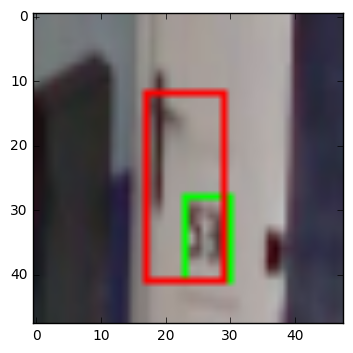

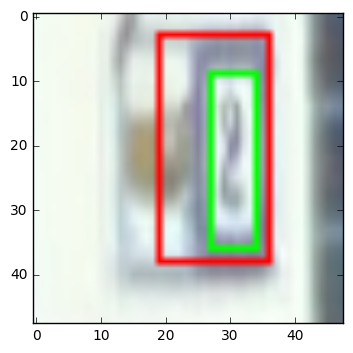

Minibatch loss at step 17600: 14.469859
Minibatch error at step 17600: 10.685845
Minibatch loss at step 17700: 16.442381
Minibatch error at step 17700: 8.606808
Minibatch loss at step 17800: 18.479479
Minibatch error at step 17800: 10.466942
Minibatch loss at step 17900: 13.471878
Minibatch error at step 17900: 7.017155
Minibatch loss at step 18000: 19.201933
Minibatch error at step 18000: 10.575785
Validation set loss at step 18000: 23.311739
Validation set average IoU at step 18000: 0.507081


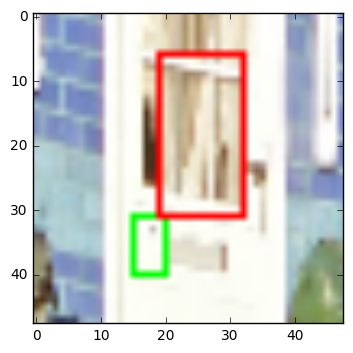

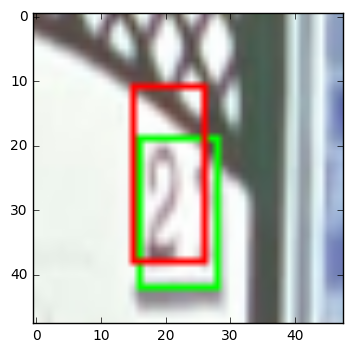

Minibatch loss at step 18100: 14.047983
Minibatch error at step 18100: 7.775283
Minibatch loss at step 18200: 13.243789
Minibatch error at step 18200: 7.504835
Minibatch loss at step 18300: 14.438127
Minibatch error at step 18300: 7.927417
Minibatch loss at step 18400: 14.988258
Minibatch error at step 18400: 10.623336
Minibatch loss at step 18500: 12.367547
Minibatch error at step 18500: 5.965025
Validation set loss at step 18500: 23.351063
Validation set average IoU at step 18500: 0.500682


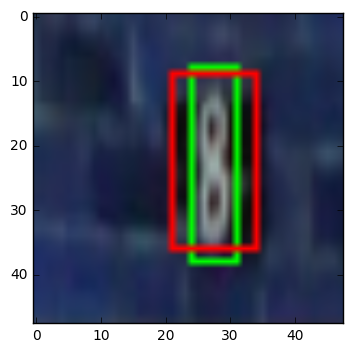

Minibatch loss at step 18600: 19.727003
Minibatch error at step 18600: 12.898033
Minibatch loss at step 18700: 14.035583
Minibatch error at step 18700: 7.823238
Minibatch loss at step 18800: 13.357570
Minibatch error at step 18800: 5.705995
Minibatch loss at step 18900: 15.468419
Minibatch error at step 18900: 9.674323
Minibatch loss at step 19000: 15.796581
Minibatch error at step 19000: 8.688774
Validation set loss at step 19000: 21.563864
Validation set average IoU at step 19000: 0.508549


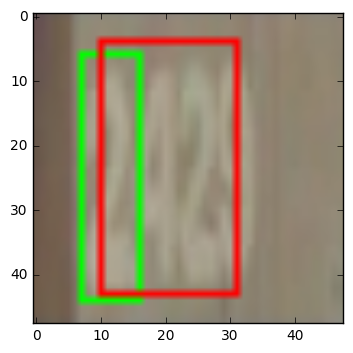

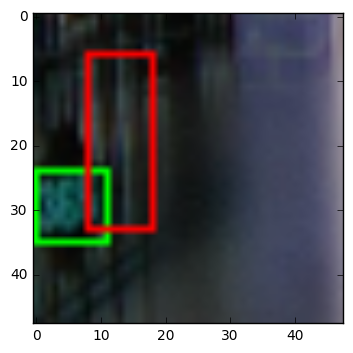

Minibatch loss at step 19100: 16.682333
Minibatch error at step 19100: 8.855642
Minibatch loss at step 19200: 18.074602
Minibatch error at step 19200: 8.653212
Minibatch loss at step 19300: 22.064476
Minibatch error at step 19300: 13.372375
Minibatch loss at step 19400: 17.387589
Minibatch error at step 19400: 7.558051
Minibatch loss at step 19500: 15.898251
Minibatch error at step 19500: 10.925798
Validation set loss at step 19500: 23.069792
Validation set average IoU at step 19500: 0.508563


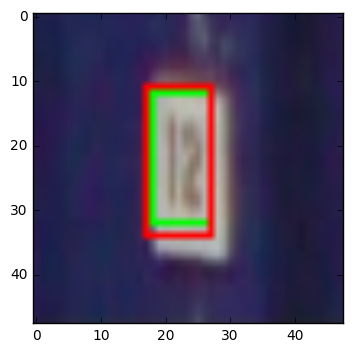

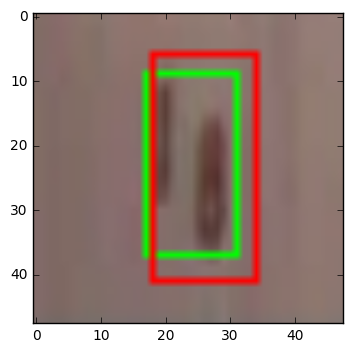

Minibatch loss at step 19600: 18.506041
Minibatch error at step 19600: 9.409538
Minibatch loss at step 19700: 16.864834
Minibatch error at step 19700: 9.280842
Minibatch loss at step 19800: 14.732719
Minibatch error at step 19800: 9.913412
Minibatch loss at step 19900: 13.594995
Minibatch error at step 19900: 8.829756
Minibatch loss at step 20000: 15.537559
Minibatch error at step 20000: 7.434968
Validation set loss at step 20000: 23.637638
Validation set average IoU at step 20000: 0.507288


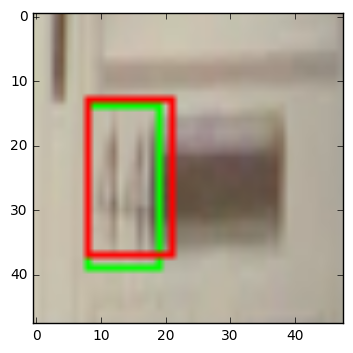

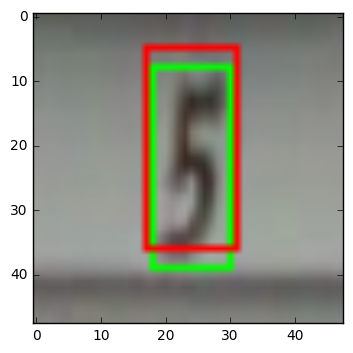

Test set loss at step 20000: 24.757212
Model saved in file: model/CNN_SVHN_BB


In [87]:
num_steps = 20001
model_path = 'model/'
if not os.path.exists(model_path):
    os.makedirs(model_path)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
        batch_dataset = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset: batch_dataset, tf_train_labels: batch_labels}

        _, l, e, predictions = session.run([optimizer, train_loss, train_error, train_logits], feed_dict=feed_dict)
        
        if (step % 100 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch error at step %d: %f' % (step, e))

        if (step % 500 == 0):
            print('=' * 50)
            error = valid_error.eval()
            print('Validation set loss at step %d: %f' % (step, error))
            
            predicted_labels = np.int32(valid_logits.eval())
            IoU_sum = 0
            for i in xrange(len(predicted_labels)):
                IoU_sum = IoU_sum + IoU_calculation(valid_labels[i], predicted_labels[i])
            IoU_average = float(IoU_sum) / len(predicted_labels)
            print('Validation set average IoU at step %d: %f' % (step, IoU_average))
                
            for i in xrange(2):
                index = np.random.randint(len(valid_dataset))
                bbox_compare(SVHN_valid_dataset[index], bbox_label = valid_labels[index], bbox_prediction = predicted_labels[index])
            print('=' * 50)
        
            
    print('=' * 50)
    print('Test set loss at step %d: %f' % (step, test_error.eval()))
    print('=' * 50)
    
    save_path = saver.save(sess = session, save_path = model_path + 'CNN_SVHN_BB')
    print("Model saved in file: %s" % save_path)